# [Sequence To Sequence](https://wikidocs.net/24996)

seq2seq는 번역기에서 대표적으로 사용되는 모델입니다.

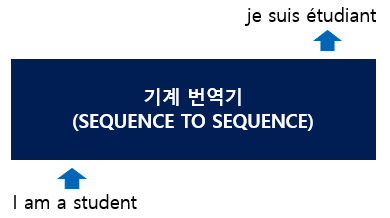

## Encoder
1. 인코더의 은닉 상태를 적절한 값(ex. 영벡터)으로 초기화한다.
2. 매 시점(time step)원문의 단어(token)가 입력되면(단어의 임베딩이 입력되면) 인코더는 이를 이용해 은닉 상태를 업데이트를 한다.
3. 입력 시퀀스의 끝까지 이 과정을 반복하면 인코더의 최종 은닉 상태는 입력 시퀀스의 정보를 압축 요약한 정보를 담고 있게 된다.
4. 이 마지막 시점에서의 인코더 은닉 상태를 컨텍스트 벡터라고 하고, 이 값은 디코더로 넘어간다.

## Decoder
1. 디코더는 전달받은 컨텍스트 벡터로 자신의 은닉 상태를 초기화한다.
2. 그리고 매 시점 자신이 바로 직전 시점에 출력했던 단어를 입력으로 받아, 자신의 은닉 상태를 업데이트하고, 이를 이용해 다음 단어를 예측한다. (최초 시점에서는 시퀀스 시작을 의미하는 `<sos>` 토큰(Start Of Sequence)을 입력으로 받는다.)
3. 이 과정을 정해진 반복 횟수 또는 시퀀스 끝을 나타내는 `<eos>` 토큰(End Of Sequence)이 나올 때까지 수행한다.

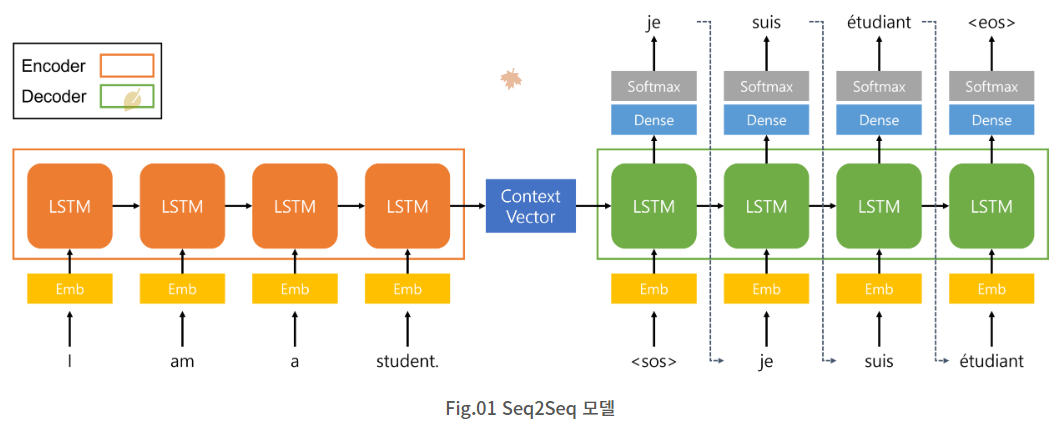

In [65]:
# decoder는 target을 인풋데이터로 사용한다 (학습데이터로)
#위의 그림에서 context vector는 hidden의 데이터이다 즉, 모델의 압축데이터이다.
#hidden데이터를 공유해야하기때문에 encoder의 hidden_shape과 decoder의 hidden_shape은 같다. 즉(layer* direction, batch_size, hidden_size)가 같아야한다.

#special token -> ex) unknown,
#sos : strat of sentence
#eos : end of sentence

# 구현

In [66]:
import numpy as np
import torch
import torch.nn as nn

In [67]:
n_step = 5 # 글자의 최대 길이 #input_size
n_hidden = 128

## 데이터

### 데이터 생성

In [68]:
seq_data = [['man', 'women'], ['black', 'white'], ['king', 'queen'], ['girl', 'boy'], ['up', 'down'], ['high', 'low']] #man을 넣으면 women을 예측하는 모델(번역원리처럼)
np.array(seq_data).shape

(6, 2)

In [69]:
batch_size = len(seq_data) #전체 데이터의 길이 6개
batch_size

6

### 데이터 토큰화

In [70]:
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz'] # S(시작), E(끝), P(패딩) #3가지 특수 토큰을 강제로 넣는다. #보통 대문자는 특수토큰, 소문자는 일반토큰이다.
len(char_arr)

29

### 데이터 사전

In [71]:
num_dic = {n: i for i, n in enumerate(char_arr)} #토큰화하고 사전만들기
n_class = len(num_dic)
n_class

29

In [72]:
char_arr[5], num_dic['c']

('c', 5)

## 학습 데이터

### 학습 데이터 생성

In [73]:
def make_batch():
    input_batch, output_batch, target_batch = [], [], []


    for seq in seq_data:
        for i in range(2):
            seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩 , n_step = 5

        input = [num_dic[n] for n in seq[0]]
        output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작 #아렇게 되면 반복될때마다 s가 붙지 않을까? input은 man이라고 해도 S + woman으로 모든 데이터가 만들어지지않을까?
        target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

        input_batch.append(np.eye(n_class)[input]) # one-hot
        output_batch.append(np.eye(n_class)[output]) # one-hot
        target_batch.append(target) # not one-hot

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [74]:
input_batch, output_batch, target_batch = make_batch()
# input_batch: (batch_size(데이터 수), input_size(최대 글자 수), embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수), embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(S) + 최대 글자 수))
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [75]:
n_step

5

In [76]:
seq_data

[['manPP', 'women'],
 ['black', 'white'],
 ['kingP', 'queen'],
 ['girlP', 'boyPP'],
 ['upPPP', 'downP'],
 ['highP', 'lowPP']]

In [77]:
seq = ['manPP', 'women'] #n_step(5) - len(seq[0]) = 2이므로 2개의 padding값이 들어간다.

In [78]:
input = [num_dic[n] for n in seq[0]]
input #뒤의 2들은 "P" padding값이다.

[15, 3, 16, 2, 2]

In [79]:
[num_dic[n] for n in seq[1]]

[25, 17, 15, 7, 16]

In [80]:
output = [num_dic[n] for n in ("S" + seq[1])]
output #앞의 0은 "S"(soe)이다.

[0, 25, 17, 15, 7, 16]

In [81]:
target = [num_dic [n]for n in (seq[1]+"E")]
target #뒤의 1은  "E"(eoe)이다.

[25, 17, 15, 7, 16, 1]

In [82]:
np.eye(n_class)[input]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [83]:
np.eye(n_class)[output]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [84]:
np.eye(n_class)[target]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### 디버깅

In [85]:
seq_data

[['manPP', 'women'],
 ['black', 'white'],
 ['kingP', 'queen'],
 ['girlP', 'boyPP'],
 ['upPPP', 'downP'],
 ['highP', 'lowPP']]

In [86]:
# 1. 데이터 구조 파악 : 리스트1 , 리스트2
# 2. 리스트2에서 가장 큰 길이를 찾아서 새로운 리스트3에 담음
# 2-1. 리스트3: 리스트2에서 가장 큰 길이들이 모임
# 3. 리스트3에서 가장 큰 수 찾음
tmp = [ len(row[0]) if len(row[0]) > len(row[1]) else len(row[1]) for row in seq_data ]
tmp

[5, 5, 5, 5, 5, 5]

In [87]:
max(tmp)

5

In [88]:
n_step # 글자의 최대 길이

5

In [89]:
for seq in [['man', 'women']]:
    for i in range(2):
        seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩

    input = [num_dic[n] for n in seq[0]]
    output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
    target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

    break

In [90]:
seq

['manPP', 'women']

In [91]:
input

[15, 3, 16, 2, 2]

In [92]:
output

[0, 25, 17, 15, 7, 16]

In [93]:
target

[25, 17, 15, 7, 16, 1]

In [94]:
len(np.eye(n_class)[input]) # 5개 글자!!!

5

In [95]:
np.eye(n_class)[input][0] # 글자별 원핫인코딩!!

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Seq2Seq 모델 생성

In [96]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()

        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 인코딩
        # drop 하는 이유 -> 과적합 제거
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 디코딩
        # drop 하는 이유 -> 과적합 제거
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, enc_input, enc_hidden, dec_input):
        enc_input = enc_input.transpose(0, 1) # enc_input: [inputsize(max_len(=n_step, time step)), batch_size, n_class=embedding_size]
        dec_input = dec_input.transpose(0, 1) # dec_input: [inputsize(max_len(=n_step, time step)), batch_size, n_class=embedding_size]

        # enc_states : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        _, enc_states = self.enc_cell(enc_input, enc_hidden)# _,enc_stated인 이유는 hiddenlayer의 output을 안쓰기때문에 _이걸로 안쓰겠다고 정의 # context vector
        # outputs : [max_len+1(=6), batch_size, num_directions(=1) * n_hidden(=128)]
        outputs, _ = self.dec_cell(dec_input, enc_states) # output,_ 인이유 output을 사용해서 다음값을 예측함  hidden은 쓰지 않음
        _outputs = outputs.transpose(0,1) #outpus= (input, batch,n_hidden) ->_outputs= (batch_size,input_size(1(E)+최대 글자수), n_hidden)
        # fully Dense(batch, input,hidden)
        pred = self.fc(_outputs) # pred : [batch_size,max_len+1(=6), n_class]
        return pred

In [97]:
enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 인코딩
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 디코딩

In [98]:
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
dec_cell

RNN(29, 128, dropout=0.5)

In [99]:
 # enc_cell.shape -> 29, inputsize = 29개의 알파벳, 128개의 hidden 으로 하겠다.
# dec_cell

### 디버깅

In [100]:
input_batch, output_batch, target_batch = make_batch()
# input_batch: (batch_size(데이터 수), input_size(최대 글자 수), embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수), embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(E) + 최대 글자 수))
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [101]:
n_class, n_hidden

(29, 128)

In [102]:
enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
fc = nn.Linear(n_hidden, n_class)

In [103]:
enc_input = input_batch.transpose(0, 1)
# enc_input: (input_size(최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
enc_input.shape

torch.Size([5, 6, 29])

In [104]:
dec_input = output_batch.transpose(0, 1)
# dec_input: (input_size(1(S) + 최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
dec_input.shape

torch.Size([6, 6, 29])

In [105]:
enc_hidden = torch.zeros(1, batch_size, n_hidden) # 초기값
enc_hidden.shape

torch.Size([1, 6, 128])

In [106]:
_, enc_states = enc_cell(enc_input, enc_hidden)
_.shape, enc_states.shape # enc_states (layer_size * num_directions, batch_size, n_hidden)

(torch.Size([5, 6, 128]), torch.Size([1, 6, 128]))

In [107]:
outputs, _ = dec_cell(dec_input, enc_states)
outputs.shape, _.shape # outputs (input_size(1(E) + 최대 글자 수), batch_size, n_hidden)

(torch.Size([6, 6, 128]), torch.Size([1, 6, 128]))

In [108]:
pred = fc(outputs)
pred.shape # outputs (input_size(1(E) + 최대 글자 수), batch_size, embedding_size)

torch.Size([6, 6, 29])

## 학습

In [109]:
model = Seq2Seq()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

In [110]:
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [111]:
for epoch in range(5000):
    # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
    hidden = torch.zeros(1, batch_size, n_hidden)
    # input_batch : [batch_size, max_len(=n_step, time step), n_class]
    # output_batch : [batch_size, max_len+1(=n_step, time step) (becase of 'S' or 'E'), n_class]
    # target_batch : [batch_size, max_len+1(=n_step, time step)], not one-hot
    output = model(input_batch, hidden, output_batch)
    # output : [max_len+1, batch_size, n_class]
    # output = output.transpose(0, 1) # [batch_size, max_len+1(=6), n_class] # 강사님 방식대로 하려면 이것은 안하게

    loss = 0
    for i in range(0, len(target_batch)):
        # output[i] : [batch_size[i], max_len+1(=6), n_class]
        # target_batch[i] : [batch_size[i], max_len+1(=6)]

        # print(f'output: {output[i].shape}')
        # print(f'target_batch: {target_batch[i].shape}')
        # break
        loss += criterion(output[i], target_batch[i])
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.003371
Epoch: 2000 cost = 0.000907
Epoch: 3000 cost = 0.000384
Epoch: 4000 cost = 0.000191
Epoch: 5000 cost = 0.000103


## 테스트

In [128]:
def make_testbatch(input_word):
    input_batch, output_batch = [], []

    input_w = input_word + 'P' * (n_step - len(input_word)) # P: 패딩 추가
    input = [num_dic[n] for n in input_w]
    output = [num_dic[n] for n in 'S' + 'P' * n_step] # S와 P로 output 구성
    print(f'input_w:{input_w}/output_w{output}')
    input_batch = np.eye(n_class)[input]
    output_batch = np.eye(n_class)[output]

    return torch.FloatTensor(input_batch).unsqueeze(0), torch.FloatTensor(output_batch).unsqueeze(0)

In [129]:
input_batch, output_batch = make_testbatch('upp')
input_batch.shape, output_batch.shape

input_w:uppPP/output_w[0, 2, 2, 2, 2, 2]


(torch.Size([1, 5, 29]), torch.Size([1, 6, 29]))

In [130]:
hidden = torch.zeros(1, 1, n_hidden)
hidden.shape

torch.Size([1, 1, 128])

In [131]:
output = model(input_batch, hidden, output_batch)
output.shape

torch.Size([1, 6, 29])

In [132]:
output[0][0] # max: 16.0384

tensor([-1.5666, -1.1190,  1.8295, -1.4737,  3.0623, -2.7425, 15.8631, -1.4908,
        -1.5999, -1.6056, -4.6170, -3.3049, -2.5310, -2.0666,  3.8186, -4.1764,
         2.2099,  0.9443, -1.0561,  4.2144, -1.5482, -2.1441, -3.3172,  0.7533,
        -1.8025,  4.1410, -1.6860, -6.8444, -1.3304],
       grad_fn=<SelectBackward0>)

In [133]:
output.data.max(2, keepdim=True) # values: 최대값, indices: 인덱스값

torch.return_types.max(
values=tensor([[[15.8631],
         [16.1712],
         [14.9654],
         [13.4931],
         [14.9607],
         [15.7150]]]),
indices=tensor([[[ 6],
         [17],
         [25],
         [16],
         [ 2],
         [ 1]]]))

In [136]:
predict = output.data.max(2, keepdim=True)[1]

predict.shape


torch.Size([1, 6, 1])

In [137]:
decoded = [char_arr[i] for i in predict[0]]
decoded # E: 문장의 끝을 나타냄, P: 패딩

['d', 'o', 'w', 'n', 'P', 'E']

In [138]:
# Test
def translate(word):
    input_batch, output_batch = make_testbatch(word)

    # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)
    output = model(input_batch, hidden, output_batch)
    # output : [max_len+1(=6), batch_size(=1), n_class]

    predict = output.data.max(2, keepdim=True)[1] # select n_class dimension
    decoded = [char_arr[i] for i in predict]
    end = decoded.index('E')
    translated = ''.join(decoded[:end])

    return translated.replace('P', '')

In [140]:
print('test')
print('man ->', translate('man'))
print('mans ->', translate('mans'))
print('king ->', translate('king'))
print('black ->', translate('black'))
print('upp ->', translate('upp'))

test
input_w:manPP/output_w[0, 2, 2, 2, 2, 2]


TypeError: ignored